# RFMSPPL clustering using DBSCAN

DBSCSAN stands for "Density-Based Spatial Clustering of Applications with Noise", it's proved efficient when your data may have outliers
or with skewed datasets.

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

rfmsppl = pd.read_csv("./../../../output/rfmsppl.csv")
y = rfmsppl["review_score"]

X_train, X_test, y_train, y_test = train_test_split(
    rfmsppl, y, test_size=0.2, random_state=42, stratify=y
)
rfmsppl = X_test

rfmsppl

recency  frequency  monetary  nb_orders          first_order  \
43517    450.0   0.062500     29.50        1.0  2017-06-05 20:41:09   
52729     34.0   0.500000     72.07        1.0  2018-07-26 16:57:05   
58266    468.0   0.058824    194.91        1.0  2017-05-18 21:05:48   
7281     521.0   0.055556     47.95        1.0  2017-03-27 13:14:39   
19387    225.0   0.125000     39.84        1.0  2018-01-16 18:34:46   
...        ...        ...       ...        ...                  ...   
69873    137.0   0.166667     31.03        1.0  2018-04-14 16:48:42   
77668    129.0   0.200000    111.42        1.0  2018-04-22 19:58:22   
64782    192.0   0.142857    134.34        1.0  2018-02-19 09:45:59   
72891    209.0   0.125000     43.09        1.0  2018-02-01 22:14:52   
67805    108.0   0.200000    153.72        1.0  2018-05-13 20:35:01   

                last_order  days_between_orders  scoring_R  scoring_F  \
43517  2017-06-05 20:41:09                    0          1          1   
52729  2018-07-26 16:57:05                    0          5          5   
58266  2017-05-18 21:05:48                    0          1          1   
7281   2017-03-27 13:14:39                    0          1          1   
19387  2018-01-16 18:34:46                    0          3          3   
...                    ...                  ...        ...        ...   
69873  2018-04-14 16:48:42                    0          4          4   
77668  2018-04-22 19:58:22                    0          4          4   
64782  2018-02-19 09:45:59                    0          3          3   
72891  2018-02-01 22:14:52                    0          3          3   
67805  2018-05-13 20:35:01                    0          4          4   

       scoring_M  ...  customer_zip_code_prefix          customer_city  \
43517          1  ...                     72110               brasilia   
52729          2  ...                     19700     paraguacu paulista   
58266          4  ...                     30770         belo horizonte   
7281           1  ...                     29645  santa maria de jetiba   
19387          1  ...                     17120                 agudos   
...          ...  ...                       ...                    ...   
69873          1  ...                      1307              sao paulo   
77668          3  ...                      5782              sao paulo   
64782          4  ...                      9725  sao bernardo do campo   
72891          1  ...                     89707              concordia   
67805          4  ...                     37200                 lavras   

       customer_state  scoring_PR payment_sequential  payment_installments  \
43517              DF           5                1.0                   1.0   
52729              SP           6                1.0                   1.0   
58266              MG           6                1.0                   1.0   
7281               ES           1                1.0                   4.0   
19387              SP           2                1.5                   1.5   
...               ...         ...                ...                   ...   
69873              SP           7                1.0                   1.0   
77668              SP           8                1.0                   2.0   
64782              SP           7                1.0                   1.0   
72891              SC           8                1.0                   1.0   
67805              MG           7                1.0                   4.0   

       payment_value_boleto payment_value_voucher payment_value_credit_card  \
43517              0.000000                   0.0                 29.500000   
52729              0.000000                   0.0                 72.070000   
58266              0.000000                   0.0                194.910004   
7281               0.000000                   0.0                 47.950001   
19387              0.000000                   0.0       

It's not required by DBSCAN to have variables with normal distributions, but it never hurt to scale our variables:

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scalar_vars = rfmsppl[
    rfmsppl.select_dtypes(exclude=["object", "category"]).columns
]

scaled_customers = scaler.fit_transform(scalar_vars)

scaled_customers

array([[ 1.41751156, -0.69331937, -0.59786197, ..., -0.13537486,
        -0.48407048, -0.05569846],
       [-1.33051672,  1.69928597, -0.38657031, ..., -0.13537486,
        -0.22119738, -0.05569846],
       [ 1.53641663, -0.7134253 ,  0.22313295, ..., -0.13537486,
         0.53734931, -0.05569846],
       ...,
       [-0.28679444, -0.25386124, -0.07749979, ..., -0.13537486,
        -0.6662353 , -0.05569846],
       [-0.17449521, -0.3515186 , -0.53040945, ..., -0.13537486,
        -0.6662353 , -0.05569846],
       [-0.84168477,  0.05864231,  0.01869077, ..., -0.13537486,
         0.2829978 , -0.05569846]])

We need to determine the optimal value for epsilon (eps) and the number of samples (min_samples).
Two points are considered neighbors if the distance between the two points is below the threshold epsilon.

As stated by most of data scientists, you may chose the number of samples according to your business.
If you have no idea about the number of clusters for this kind of business, you can apply the [following formula](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf):

min_samples = 2 * (number of variables)

In our case, we have 13 variables so we select **26** as `min_samples` value.

Then we will estimate an optimal value for epsilon.

In [13]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=26).fit(scaled_customers)
distances, idx = nearest_neighbors.kneighbors(scaled_customers)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
fig = px.line(None, y=distances, title="Evaluation of epsilon")
fig.show()

It look likes a value of eps around [3-5] is optimal.

eps  n_clusters  noise_points  silhouette_score
0   3.0           4           495          0.316550
1   3.2           3           416          0.319759
2   3.4           3           353          0.322866
3   3.6           3           307          0.325895
4   3.8           3           269          0.326805
5   4.0           3           224          0.330143
6   4.2           3           200          0.330928
7   4.4           3           178          0.332877
8   4.6           3           159          0.332122
9   4.8           3           144          0.332925
10  5.0           4            99          0.333488
11  5.2           2            78          0.467918
12  5.4           2            67          0.470982
13  5.6           2            55          0.471350
14  5.8           2            52          0.471474

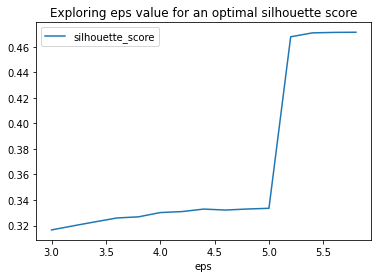

In [14]:
from sklearn import metrics
import numpy as np

# Compute DBSCAN
report = []
for eps_value in np.arange(3, 6, 0.2):
    dbscan = DBSCAN(eps=eps_value, min_samples=26, n_jobs=-1).fit(scaled_customers)
    labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    score = metrics.silhouette_score(scaled_customers, labels)
    report.append(
        {
            "eps": eps_value,
            "n_clusters": n_clusters_,
            "noise_points": n_noise_,
            "silhouette_score": score,
        }
    )

df_report = pd.DataFrame(report)
df_report.plot(
    title="Exploring eps value for an optimal silhouette score",
    x="eps",
    y="silhouette_score",
)

df_report.head(15)

An optimal eps value is : **5** for **4** clusters

In [15]:
# Compute DBSCAN
dbscan = DBSCAN(eps=5, min_samples=26).fit(scaled_customers)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(
    "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(scaled_customers, labels)
)

Estimated number of clusters: 4
Estimated number of noise points: 99
Silhouette Coefficient: 0.333


In [16]:
rfmsppl["cluster"] = labels
rfmsppl.cluster = rfmsppl.cluster.astype("category")

#### Clustering visualisation

In [17]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, learning_rate="auto", init="random", n_jobs=-1)
projected_customers = tsne.fit_transform(scaled_customers)

fig = px.scatter(
    projected_customers,
    x=0,
    y=1,
    color=rfmsppl.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

In [18]:
# cluster for value equals to -1 is noise
dataset = rfmsppl[rfmsppl.cluster != -1]
fig = px.scatter_3d(dataset, x="recency", y="monetary", z="frequency", color="cluster")
fig.show()

### Conclusions on DBSCAN

Sadly, as we can see the frequency have the biggest impact and there is nothing more we can learn from this clustering if we use only RFM metrics.
If we want a better clustering, we must integrate more data.